## Load Data

In [1]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pd

DATA_PATH = './data'
DATA_FILE_NAME = 'Brugge_en_d.mat'

data_dir = pjoin(DATA_PATH, DATA_FILE_NAME)
mat_contents = sio.loadmat(data_dir)

data = mat_contents['en_d'][0, 0]

In [2]:
# TIME
# series of days (498 days between day 0-3648), not continuous
# not only integer, contains several float
print("TIME")
print("numpy array shape: {}".format(data['TIME'].shape))

TIME
numpy array shape: (498, 1)


In [ ]:
# WBHP
# Well Bottom Hole Pressure
# daily data 498 days for 104 models
print("WBHP")
print("numpy array shape: {}".format(data['WBHP'].shape))
# Producers P1-P20
# and Injectors I1-I10
# shape of each is 498x104 double
print("Producer P1 numpy array shape: {}".format(data['WBHP'][0,0]['P1'].shape))
print("Injectre I1 numpy array shape: {}".format(data['WBHP'][0,0]['I1'].shape))

In [ ]:
# WWCT
# Well Water Cut: water/entire_liquid
print("WWCT")
print("numpy array shape: {}".format(data['WWCT'].shape))
# Producers P1-P20
print("Producer P1 numpy array shape: {}".format(data['WWCT'][0,0]['P1'].shape))

In [ ]:
# WOPR
# Well Oil Production Rate: bbl/day
# What we want to forecast, this will be used as label
print("WOPR")
print("numpy array shape: {}".format(data['WOPR'].shape))
# Producers P1-P20, index 0-19
print("Producer P1 numpy array shape: {}".format(data['WOPR'][0,0]['P1'].shape))

In [ ]:
# WWPR
# Well Water Production Rate
print("WWPR")
print("numpy array shape: {}".format(data['WWPR'].shape))
# Producers P1-P20
print("Producer P1 numpy array shape: {}".format(data['WWPR'][0,0]['P1'].shape))

In [ ]:
# WWIR
# Well Water Injection Rate
print("WWIR")
print("numpy array shape: {}".format(data['WWIR'].shape))
# Injectors I1-I10
print("Injector 1 numpy array shape: {}".format(data['WWIR'][0,0]['I1'].shape))

In [ ]:
# FOPT
# Field Oil Production Total: sum of WOPR * days
print("FOPT")
print("numpy array shape: {}".format(data['FOPT'].shape))
# FWPT
# Field Water Production Total
print("FWPT")
print("numpy array shape: {}".format(data['FWPT'].shape))
# FPR
# Field Production Rate: FOPR + FWPR
print("FPR")
print("numpy array shape: {}".format(data['FPR'].shape))

In [ ]:
# WWBT
# Well W B Total
print("WWBT")
print("numpy array shape: {}".format(data['WWBT'].shape))
# Producers P5,P11-P20
print("Producer P5 numpy array shape: {}".format(data['WWBT'][0,0]['P5'].shape))

# Data Preparation

각 model 별로 아래와 같은 Dataframe 을 만들자.

|date|WOPR|WBHP|WWCT|WWPR|
|--|--|--|--|--|
|0.0|0.0|0.0|0.0|0.0|
|1.0|0.0|0.0|0.0|0.0
| . | . | . | . | . |
|3641.0|1998.772|1393.615|0.001552|3.107502|
|3648.0|1998.775|1393.951|0.001551|3.105065|

In [3]:
#  'well_num' => dfs_dic
dic_wells = {}
contain_null = False
for well_index in range(20): # well, Producer P1-P20
    # 'model_num' => dataframe
    dic_models = {}
    well_key = 'P' + str(well_index+1)
    for model_index in range(104): # model, model 1-104
        well_data = np.array([
            data['WOPR'][0,0][well_key][:,model_index],
            data['WBHP'][0,0][well_key][:,model_index],
            data['WWCT'][0,0][well_key][:,model_index],
            data['WWPR'][0,0][well_key][:,model_index]
          ])
        # col1: WOPR, col2: WBHP, col3: WWCT, col4: WWPR
        # row1: day1, ... row 498: day3648
        well_data = well_data.T
        df = pd.DataFrame(data=well_data,
                          index=data['TIME'].flatten(),
                          columns=['WOPR', 'WBHP', 'WWCT', 'WWPR'])
        df.index.name = 'date'
        if df.isnull().values.any():
            contain_null = True
        dic_models[str(model_index+1)] = df
        
    dic_wells[str(well_index+1)] = dic_models
    
contain_null, dic_wells.keys()

(False,
 dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']))

In [ ]:
# [well_num][model_num]
print(dic_wells['1']['1'].head())
print(dic_wells['1']['1'].tail())
print(dic_wells['20']['1'].head())
print(dic_wells['20']['1'].tail())

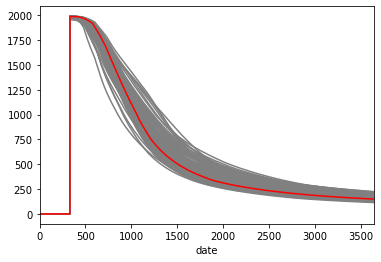

In [5]:
# plot well 20, model 1 data
import matplotlib.pyplot as plt

ax = plt.gca()

for i in range(104):
    df = dic_wells['20'][str(i + 1)]
    # model #104 is true model
    # while model #1-103 is equivalent model
    if i == 103:
        df.plot(y='WOPR', ax=ax, color='red', legend=False)
    else:
        df.plot(y='WOPR', ax=ax, color='gray', legend=False)

plt.show()

# Data Preprocessing for LSTM

LSTM에 맞게 data를 전처리하자.
Multivariate, multi-step Forecasting을 하는 것이 목적이다. 

Input dimension은 4로,

- WOPR
- WBHP
- WWCT
- WWPR

을 사용한다.

sequence(step size)는 5로 한다. 즉, 이전 5개(t-1, t-2, t-3, t-4, t-5)의 time step의 data를 input으로 하여 현재 time step t의 WOPR을 예측한다.

In [6]:
def series_to_supervised(dataframe, n_in=1, n_out=1, dropnan=True):
    '''
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a dataframe
        n_in: Number of lag observation as input, number of sequence
        n_out: Number of observations as output, output dimension
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    '''
    n_vars = len(dataframe.columns)
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, ... , t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
target_df = dic_wells['20']['103']

reframed = series_to_supervised(target_df, n_in=5, n_out=1)
reframed.loc[:, :] = scaler.fit_transform(reframed.loc[:, :])
print(reframed.loc[:, :].shape)
print(reframed.tail())

(493, 24)
        var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var1(t-4)  var2(t-4)  \
date                                                                       
3620.0   0.065021   0.998405   0.999313   0.999312   0.064833   0.998408   
3637.0   0.064833   0.998862   0.999512   0.999512   0.064458   0.999339   
3638.0   0.064458   0.999794   0.999911   0.999911   0.064438   0.999389   
3641.0   0.064438   0.999845   0.999933   0.999933   0.064375   0.999545   
3648.0   0.064375   1.000000   1.000000   1.000000   0.064192   1.000000   

        var3(t-4)  var4(t-4)  var1(t-3)  var2(t-3)  ...  var3(t-2)  var4(t-2)  \
date                                                ...                         
3620.0   0.999316   0.999317   0.064458   0.998468  ...   0.999346   0.999347   
3637.0   0.999716   0.999716   0.064438   0.998519  ...   0.999414   0.999414   
3638.0   0.999737   0.999738   0.064375   0.998674  ...   0.999609   0.999609   
3641.0   0.999804   0.999805   0.064192   0.999129  

training set과 test set을 분리하자.

In [7]:
eff_time_step = len(reframed[['var1(t)']])
train_size = int(0.3 * eff_time_step)
test_size = eff_time_step - train_size

data_to_numpy = reframed.to_numpy()
train, test = data_to_numpy[:train_size, :], data_to_numpy[train_size:, :]

train_X, train_y = train[:, :-4], train[:, -4]
test_X, test_y = test[:, :-4], test[:, -4]
# reshape input to be 3D [samples, timesteps, features]
input_timesteps = 5
input_dimension = 4
train_X = train_X.reshape((train_X.shape[0], input_timesteps, input_dimension))
test_X = test_X.reshape((test_X.shape[0], input_timesteps, input_dimension))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(147, 5, 4) (147,) (346, 5, 4) (346,)


# Define and Fit the model

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design the network
model = Sequential()
model.add(LSTM(50, input_shape=(input_timesteps, input_dimension)))
model.add(Dense(1))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 147 samples, validate on 346 samples
Epoch 1/50
 - 1s - loss: 0.4981 - val_loss: 0.0720
Epoch 2/50
 - 0s - loss: 0.4302 - val_loss: 0.1342
Epoch 3/50
 - 0s - loss: 0.3629 - val_loss: 0.2349
Epoch 4/50
 - 0s - loss: 0.2939 - val_loss: 0.3580
Epoch 5/50
 - 0s - loss: 0.2234 - val_loss: 0.4750
Epoch 6/50
 - 0s - loss: 0.1750 - val_loss: 0.5387
Epoch 7/50
 - 0s - loss: 0.1489 - val_loss: 0.5609
Epoch 8/50
 - 0s - loss: 0.1331 - val_loss: 0.5510
Epoch 9/50
 - 0s - loss: 0.1222 - val_loss: 0.5186
Epoch 10/50
 - 0s - loss: 0.1138 - val_loss: 0.4717
Epoch 11/50
 - 0s - loss: 0.1072 - val_loss: 0.4160
Epoch 12/50
 - 0s - loss: 0.1026 - val_loss: 0.3567
Epoch 13/50
 - 0s - loss: 0.0996 - val_loss: 0.2982
Epoch 14/50
 - 0s - loss: 0.0973 - val_loss: 0.2432
Epoch 15/50
 - 0s - loss: 0.0945 - val_loss: 0.1941
Epoch 16/50
 - 0s - loss: 0.0890 - val_loss: 0.1682
Epoch 17/50
 - 0s - loss: 0.0649 - val_loss: 0.1713
Epoch 18/50
 - 0s - loss: 0.0369 - val_loss: 0.1557
Epoch 19/50
 - 0s - loss: 0

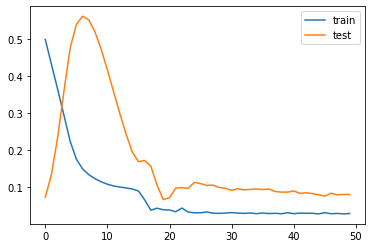

In [10]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Evaluate the model

In [11]:
# make a prediction
y_hat = model.predict(test_X)
# test_X = np.concatenate((train_X, test_X))
# y_hat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], input_timesteps * input_dimension)

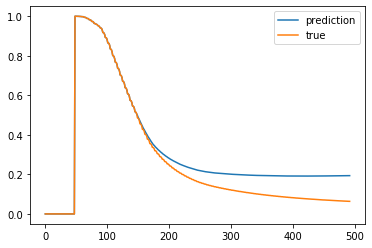

In [12]:
evaluate_array = np.array([
    np.concatenate((train_y, y_hat), axis=None),
#     y_hat.flatten(),
    np.concatenate((train_y, test_y), axis=None)
])                  
df = pd.DataFrame(data=evaluate_array.T, columns=['prediction', 'true'])

plt.plot(df[['prediction']], linestyle='-', label='prediction')
plt.plot(df[['true']], linestyle='-',label = 'true')
plt.legend()
plt.show()

In [13]:
# invert scaling for forecast
inv_y_hat = np.concatenate((y_hat, test[:, 1:]), axis = 1)
print(y_hat.shape)
# print(y_hat)
# print(test_X.shape)
# print(test_X)
print(inv_y_hat.shape)
inv_y_hat = scaler.inverse_transform(inv_y_hat)
inv_y_hat = inv_y_hat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
# print(test_y.shape, test_X[:, 1:].shape)
inv_y = np.concatenate((test_y, test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

(346, 1)
(346, 24)


In [14]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(inv_y, inv_y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 173.960
